# Multidimensional Data Processing Pipeline (Portfolio Project)

## Goal
Build a reproducible data processing pipeline for multidimensional scientific-style data using Python.

## Stack
- Python
- NumPy
- Pandas
- Matplotlib
- SQLite

## Steps
1. Load multidimensional dataset
2. Slice and reshape arrays
3. Clean and filter data
4. Aggregate into tabular form
5. Store into SQL
6. Run analytical queries
7. Visualize results

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("sqlite3: OK")

numpy: 2.0.2
pandas: 2.2.2
sqlite3: OK


In [3]:
!pip install xarray netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.2 MB/s eta 0:00:00


In [4]:
import os, textwrap
import xarray as xr

url = "https://github.com/pydata/xarray-data/raw/master/air_temperature.nc"
path = "air_temperature.nc"

if not os.path.exists(path):
    !wget -q -O {path} {url}

ds = xr.open_dataset(path)
ds

<xarray.Dataset> Size: 31MB
Dimensions:  (time: 2920, lat: 25, lon: 53)
Coordinates:
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
Data variables:
    air      (time, lat, lon) float64 31MB ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [5]:
print(ds.dims)
print("variables:", list(ds.data_vars))
print("coords:", list(ds.coords))

FrozenMappingWarningOnValuesAccess({'time': 2920, 'lat': 25, 'lon': 53})
variables: ['air']
coords: ['lat', 'lon', 'time']


In [6]:
var = list(ds.data_vars)[0]
da = ds[var]

print("selected variable:", var)
print("shape:", da.shape)
print("dtype:", da.dtype)

# один временной срез
da.isel(time=0).values.min(), da.isel(time=0).values.max()

selected variable: air
shape: (2920, 25, 53)
dtype: float64


(np.float64(227.0), np.float64(302.6))

In [7]:
sub = ds.isel(
    time=slice(0, 200),   # первые 200 временных точек
    lat=slice(0, 10),
    lon=slice(0, 10)
)

sub

<xarray.Dataset> Size: 162kB
Dimensions:  (time: 200, lat: 10, lon: 10)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2013-01-01 ... 2013-02-19T18:00:00
  * lat      (lat) float32 40B 75.0 72.5 70.0 67.5 65.0 62.5 60.0 57.5 55.0 52.5
  * lon      (lon) float32 40B 200.0 202.5 205.0 207.5 ... 217.5 220.0 222.5
Data variables:
    air      (time, lat, lon) float64 160kB ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [8]:
df = sub.to_dataframe().reset_index()
df.head()

,time,lat,lon,air
0,2013-01-01,75.0,200.0,241.2
1,2013-01-01,75.0,202.5,242.5
2,2013-01-01,75.0,205.0,243.5
3,2013-01-01,75.0,207.5,244.0
4,2013-01-01,75.0,210.0,244.1


In [9]:
print(df.shape)
df.describe()

(20000, 4)


,time,lat,lon,air
count,20000,20000.000000,20000.000000,20000.000000
mean,2013-01-25 21:00:00,63.750000,211.250000,260.351277
min,2013-01-01 00:00:00,52.500000,200.000000,226.000000
25%,2013-01-13 10:30:00,57.500000,205.000000,246.000000
50%,2013-01-25 21:00:00,63.750000,211.250000,262.790000
75%,2013-02-07 07:30:00,70.000000,217.500000,275.290000
max,2013-02-19 18:00:00,75.000000,222.500000,281.790000
std,NaN,7.180883,7.180883,14.856871


In [10]:
import sqlite3

conn = sqlite3.connect("air_data.db")

df.to_sql(
    "air_measurements",
    conn,
    if_exists="replace",
    index=False
)

print("rows in table:",
      conn.execute("select count(*) from air_measurements").fetchone()[0])

rows in table: 20000


In [11]:
query = """
SELECT
    lat,
    AVG(air) as mean_temp
FROM air_measurements
GROUP BY lat
ORDER BY lat
"""

lat_mean = pd.read_sql_query(query, conn)
lat_mean.head()

,lat,mean_temp
0,52.5,277.874790
1,55.0,276.809835
2,57.5,275.536205
3,60.0,269.582045
4,62.5,262.559605


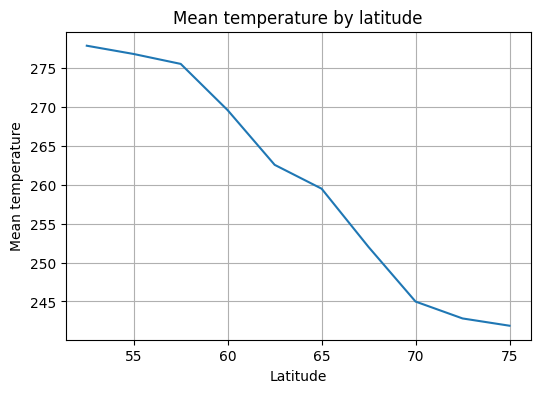

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(lat_mean["lat"], lat_mean["mean_temp"])
plt.xlabel("Latitude")
plt.ylabel("Mean temperature")
plt.title("Mean temperature by latitude")
plt.grid(True)
plt.show()

In [13]:
query_time = """
SELECT
    time,
    AVG(air) as mean_temp
FROM air_measurements
GROUP BY time
ORDER BY time
"""

time_mean = pd.read_sql_query(query_time, conn)
time_mean.head()

,time,mean_temp
0,2013-01-01 00:00:00,264.5305
1,2013-01-01 06:00:00,264.0599
2,2013-01-01 12:00:00,264.3937
3,2013-01-01 18:00:00,263.8812
4,2013-01-02 00:00:00,264.5074


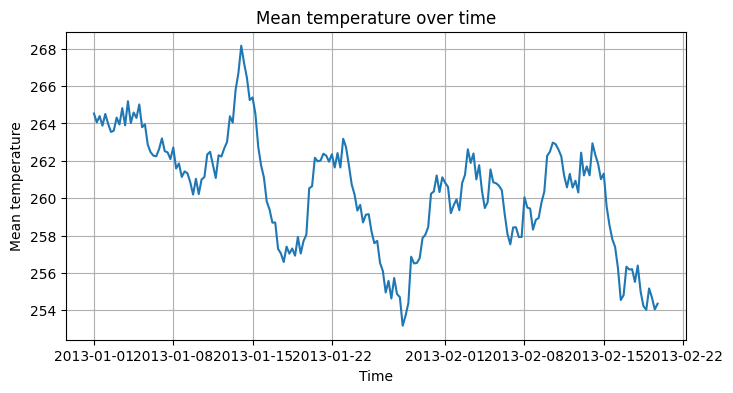

In [14]:
time_mean["time"] = pd.to_datetime(time_mean["time"])

plt.figure(figsize=(8,4))
plt.plot(time_mean["time"], time_mean["mean_temp"])
plt.title("Mean temperature over time")
plt.xlabel("Time")
plt.ylabel("Mean temperature")
plt.grid(True)
plt.show()

In [15]:
time_mean["month"] = time_mean["time"].dt.month
time_mean["day"] = time_mean["time"].dt.day
time_mean["weekday"] = time_mean["time"].dt.weekday

time_mean.head()

,time,mean_temp,month,day,weekday
0,2013-01-01 00:00:00,264.5305,1,1,1
1,2013-01-01 06:00:00,264.0599,1,1,1
2,2013-01-01 12:00:00,264.3937,1,1,1
3,2013-01-01 18:00:00,263.8812,1,1,1
4,2013-01-02 00:00:00,264.5074,1,2,2


In [16]:
weekday_mean = (
    time_mean
    .groupby("weekday")["mean_temp"]
    .mean()
    .reset_index()
)

weekday_mean

,weekday,mean_temp
0,0,260.344493
1,1,260.580509
2,2,260.832561
3,3,260.419821
4,4,260.120454
5,5,259.434654
6,6,260.693696


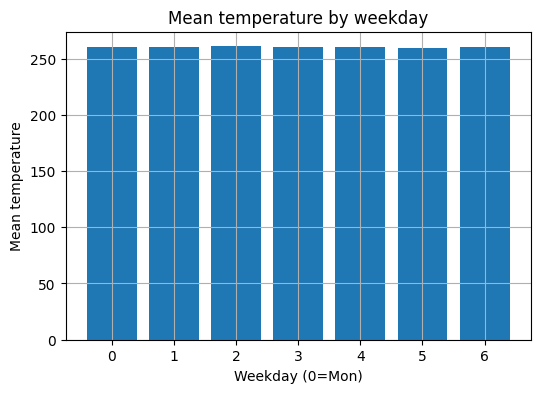

In [17]:
plt.figure(figsize=(6,4))
plt.bar(weekday_mean["weekday"], weekday_mean["mean_temp"])
plt.title("Mean temperature by weekday")
plt.xlabel("Weekday (0=Mon)")
plt.ylabel("Mean temperature")
plt.grid(True)
plt.show()

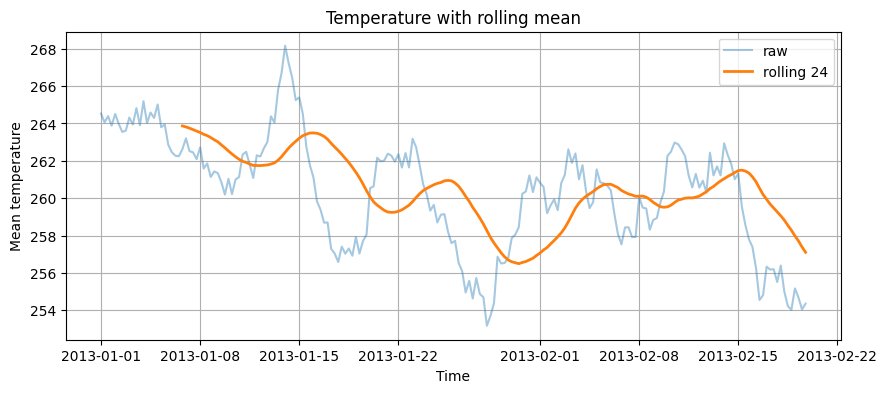

In [20]:
time_mean["rolling_24"] = (
    time_mean["mean_temp"]
    .rolling(window=24)
    .mean()
)

plt.figure(figsize=(10,4))

plt.plot(time_mean["time"], time_mean["mean_temp"], alpha=0.4, label="raw")
plt.plot(time_mean["time"], time_mean["rolling_24"], linewidth=2, label="rolling 24")

plt.legend()
plt.title("Temperature with rolling mean")
plt.xlabel("Time")
plt.ylabel("Mean temperature")
plt.grid(True)
plt.show()